# Given a Bank customer, can we build a classifier which can determine whether they will leave in the next 6 months or not?

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv


In [28]:
#Let's import all necessary libraries for our project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.utils import shuffle
from plot_metric.functions import BinaryClassification

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [29]:
#Let's open our dataset
df = pd.read_csv('/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv')
display(df.head(5))
display(df.tail(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [30]:
# Let's see what we have there
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [31]:
#Do we have null entries
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [32]:
#What about duplicates?
df.duplicated().sum()

0

In [33]:
#Let's see corr table
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.006495,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.006495,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


In [34]:
#How many males and females do we have
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [35]:
#What countries do we have
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [36]:
#Let's delete columns that we don't need for our future model
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [37]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [38]:
#Encode categorical features
df = pd.get_dummies(df, drop_first=True)

#Standardizing features
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

In [39]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,2,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,1,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,8,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,1,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,2,0.785728,1,1,1,-0.365276,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,5,-1.225848,2,1,0,-0.066419,0,0,0,1
9996,-1.391939,-0.373958,10,-0.306379,1,1,1,0.027988,0,0,0,1
9997,0.604988,-0.278604,7,-1.225848,1,0,1,-1.008643,1,0,0,0
9998,1.256835,0.293517,3,-0.022608,2,1,0,-0.125231,1,1,0,1


In [40]:
#Splitting our dataset into training, validating and test sets
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

print('Training set size:', X_train.shape[0])
print('Validating set size:', X_valid.shape[0])
print('Test set size:',X_test.shape[0])

Training set size: 6000
Validating set size: 2000
Test set size: 2000


# RandomForestClassifier model

In [41]:
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.8455
F1_Score is: 0.5282442748091603


array([[1518,   59],
       [ 250,  173]])

# LogisticRegression model

In [42]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))

confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.7915
F1_Score is: 0.2772963604852686


array([[1503,   74],
       [ 343,   80]])

#### RandomForestClassifier shows best results, let's use it for our prediction.

In [43]:
#let's use "loop" for find the best parameters for our RandomForestClassifier to get best accuracy and F1_score
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = accuracy_score(predictions, y_valid)
    fscore = f1_score(y_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    print('------------------------------------------------------')

Depth:     1       |   Estimators:     1
Accuracy: 0.8095   |   F1_Score: 0.2177
------------------------------------------------------
Depth:     1       |   Estimators:    51
Accuracy: 0.7355   |   F1_Score: 0.5187
------------------------------------------------------
Depth:     1       |   Estimators:   101
Accuracy: 0.7385   |   F1_Score: 0.5232
------------------------------------------------------
Depth:    11       |   Estimators:     1
Accuracy: 0.7455   |   F1_Score: 0.5317
------------------------------------------------------
Depth:    11       |   Estimators:    51
Accuracy: 0.8390   |   F1_Score: 0.5985
------------------------------------------------------
Depth:    11       |   Estimators:   101
Accuracy: 0.8410   |   F1_Score: 0.5985
------------------------------------------------------
Depth:    21       |   Estimators:     1
Accuracy: 0.7445   |   F1_Score: 0.4120
------------------------------------------------------
Depth:    21       |   Estimators:    51
Accurac

<b>Well it looks like with max_depth = 11 and n_estimators = 101 we got f1_score 0.5985 and accuracy score 0.8410, let's try to improve our model</b>

In [44]:
#Let's try to increase our training sets

def upsampling(features, target, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled


for repeat in range(1,10,1):
    X_upsampled, y_upsampled = upsampling(X_train, y_train, repeat)

    model = RandomForestClassifier(random_state=12345)
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}".format(f1_score(y_valid, predictions),repeat))

F1_Score: 0.532  |   Repeats :     1
F1_Score: 0.583  |   Repeats :     2
F1_Score: 0.594  |   Repeats :     3
F1_Score: 0.588  |   Repeats :     4
F1_Score: 0.585  |   Repeats :     5
F1_Score: 0.589  |   Repeats :     6
F1_Score: 0.591  |   Repeats :     7
F1_Score: 0.578  |   Repeats :     8
F1_Score: 0.584  |   Repeats :     9


In [45]:
#Let's try to decrease our training set

def downsampling(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

for i in np.arange(0.03, 0.31, 0.03):
    X_downsampled, y_downsampled = downsampling(X_train, y_train, i)
    model = RandomForestClassifier(random_state=12345)
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}".format(f1_score(y_valid, predictions), i))

F1_Score: 0.373  |  Fractions : 0.030
F1_Score: 0.429  |  Fractions : 0.060
F1_Score: 0.479  |  Fractions : 0.090
F1_Score: 0.514  |  Fractions : 0.120
F1_Score: 0.542  |  Fractions : 0.150
F1_Score: 0.553  |  Fractions : 0.180
F1_Score: 0.561  |  Fractions : 0.210
F1_Score: 0.572  |  Fractions : 0.240
F1_Score: 0.583  |  Fractions : 0.270
F1_Score: 0.587  |  Fractions : 0.300


Well, we didn't improve our model with increasing or decreasing training sets. so let's use parameters that we found in previous loop cycle.

# Testing our model

In [46]:
# Let's use best parameters for our test set
model = RandomForestClassifier(n_estimators = 101, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_test, predicted_valid))
print('Precission is: {:.3f}'.format(precision_score(y_test, predicted_valid)))
print('Recall is: {:.3f}'.format(recall_score(y_test, predicted_valid)))

Accuracy is: 0.847
F1_Score is: 0.6165413533834587
Precission is: 0.647
Recall is: 0.589


In [47]:
#For better learning let's merge our train and valid sets.
final_X = pd.concat([X_train]+[X_valid])
final_y = pd.concat([y_train]+[y_valid])

model = RandomForestClassifier(n_estimators = 101, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(final_X, final_y)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy is: {:.3f}'.format(accuracy_valid))
print('F1_Score is: {:.3f}'.format(f1_score(y_test, predicted_valid)))
print('Precission is: {:.3f}'.format(precision_score(y_test, predicted_valid)))
print('Recall is: {:.3f}'.format(recall_score(y_test, predicted_valid)))

Accuracy is: 0.845
F1_Score is: 0.625
Precission is: 0.630
Recall is: 0.620


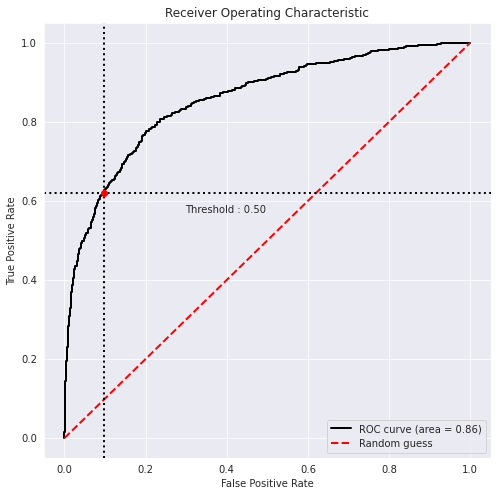

                       Roc Auc Score is: 0.857


In [48]:
#ROC AUC
y_pred = model.predict_proba(X_test)[:,1]
bc = BinaryClassification(y_test, y_pred, labels=["Class 1"])

plt.figure(figsize=(8,8))
bc.plot_roc_curve()
plt.show()
print('                       Roc Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))

### Conclusion:
- We tried two models: RandomForestClassifier and LogisticRegression, at the initial stage LogisticRegression showed the worst results, so we chose RandomForestClassifier for further work.
- With best parameters that we found we got f1_score: 0.625 and Accuracy score: 0.84. Well it looks like our model predicts well.
